<a href="https://colab.research.google.com/github/snehadevi/Duplicate-Finder/blob/main/Duplicate_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####INSTALLATION


In [1]:
!pip install -q trax

     |████████████████████████████████| 522kB 9.4MB/s 
     |████████████████████████████████| 235kB 10.8MB/s 
     |████████████████████████████████| 3.4MB 19.5MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 3.8MB 53.8MB/s 
     |████████████████████████████████| 2.1MB 56.8MB/s 
     |████████████████████████████████| 1.2MB 51.4MB/s 
     |████████████████████████████████| 368kB 50.5MB/s 
     |████████████████████████████████| 870kB 53.3MB/s 
     |████████████████████████████████| 3.3MB 50.2MB/s 


## IMPORT

In [2]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, f1_score
from nltk.corpus import stopwords 
import re
from nltk.stem import PorterStemmer
%matplotlib inline

#from pathlib import Path


# set random seeds
rnd.seed(34)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# DATA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/My\ Drive/colab_data/qstn_duplicate/

/content/drive/My Drive/colab_data/qstn_duplicate


In [7]:
#path = Path(os.getcwd())
data = pd.read_csv("questions.csv")
print(len(data))
data.isnull().sum()

404351


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
data = data.dropna()
print(len(data))
data.head(10)

404348


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [9]:
df_pos = data.loc[(data['is_duplicate'] == 1)]
print(len(df_pos))
df_pos.head()

149306


,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [10]:
df_neg = data.loc[data['is_duplicate'] == 0 ]
print(len(df_neg))
df_neg.head()

255042


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
N = len(df_pos) - 5000
train_data = df_pos[:N]
t_data = df_pos[N:]
test_data = pd.concat([df_neg[:len(t_data)], t_data])
print(len(train_data))
print(len(test_data))
#t_data.head()
#df_neg.head()
test_data.head()

144306
10000


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
y_test  = np.array(test_data['is_duplicate'])
print(y_test)
print(len(y_test))

[0 0 0 ... 1 1 1]
10000


###DATA PROCESSING

In [13]:
# duplicate_indexes = (train_data['is_duplicate']==1).to_numpy()
# print(duplicate_indexes)
# duplicate_indexes = [i for i,x in enumerate(duplicate_indexes) if x]
# print(duplicate_indexes)

In [14]:
# print(len(duplicate_indexes))

In [15]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [16]:
porter = PorterStemmer()

In [17]:
print (text_to_word_list(train_data['question1'][5]))
print (train_data['question2'][5])

['astrology', ':', 'i', 'am', 'a', 'capricorn', 'sun', 'cap', 'moon', 'and', 'cap', 'rising', 'what', 'does', 'that', 'say', 'about', 'me']
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


In [18]:
Q1_train_words = np.array(train_data['question1'].str.lower())
Q2_train_words = np.array(train_data['question2'].str.lower())
print(Q1_train_words[66424])
print(Q2_train_words[66424])

which countries will support india if china attacks india?
today if china will attack on india. which country will support india in war against of china?


In [19]:
# Q1_train_words = np.array(train_data['question1'][duplicate_indexes])
# Q2_train_words = np.array(train_data['question2'][duplicate_indexes])
# print(Q1_train_words[0])
# print(Q2_train_words[0])

In [20]:
Q1_test_words = np.array(test_data['question1'].str.lower())
Q2_test_words = np.array(test_data['question2'].str.lower())
print(Q1_test_words[7])
print(Q2_test_words[7])

motorola (company): can i hack my charter motorolla dcx3400?
how do i hack motorola dcx3400 for free internet?


In [21]:
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [22]:

from collections import defaultdict

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = [porter.stem(w) for w in (text_to_word_list(Q1_train_words[idx]))]
    Q2_train[idx] = [porter.stem(w) for w in (text_to_word_list(Q2_train_words[idx]))]
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

#print(vocab)
print(len(vocab))


The length of the vocabulary is:  20374
20374


In [23]:

print(vocab['<PAD>'])
print(vocab['astrology'])
print(vocab['Sneha'])

1
0
0


In [24]:
for i in range(len(Q1_test_words)):
  Q1_test[i] = [porter.stem(w) for w in (text_to_word_list(Q1_test_words[i]))]
  #print('q1', i, Q1_test[i])
  Q2_test[i] = [porter.stem(w) for w in (text_to_word_list(Q2_test_words[i]))]
  #print('q2', i, Q2_test[i])

In [25]:
print('Train set length: ', len(Q1_train) ) 
print('Test set length: ', len(Q1_test) ) 

Train set length:  144306
Test set length:  10000


In [26]:
print(Q1_train[0])
print(Q1_test[0])

['astrolog', ':', 'i', 'am', 'a', 'capricorn', 'sun', 'cap', 'moon', 'and', 'cap', 'rise', 'what', 'doe', 'that', 'say', 'about', 'me']
['what', 'is', 'the', 'step', 'by', 'step', 'guid', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']


###CONVERTING INTO TENSOR

In [27]:
for i in range(len(Q1_train)):
  Q1_train[i] = [vocab[word] for word in Q1_train[i]]
  Q2_train[i] = [vocab[word] for word in Q2_train[i]]

for i in range(len(Q1_test)):
  Q1_test[i] = [vocab[word] for word in Q1_test[i]]
  Q2_test[i] = [vocab[word] for word in Q2_test[i]]


In [28]:
print(Q1_train_words[0])
print(Q1_train[0])
print(Q1_test_words[0])
print(Q1_test[0])


astrology: i am a capricorn sun cap moon and cap rising...what does that say about me?
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 9, 12, 13, 14, 15, 16, 17, 18]
what is the step by step guide to invest in share market in india?
[13, 134, 66, 878, 88, 878, 4272, 30, 1080, 21, 880, 455, 21, 266]


In [29]:
cut_point = int(len(Q1_train)*.9)
training_Q1 = Q1_train[:-10000]
training_Q2 = Q2_train[:-10000]

eval_Q1 = Q1_train[-10000:]
eval_Q2 = Q2_train[-10000:]

print(len(training_Q1))
print(len(eval_Q1))

134306
10000


In [30]:
def batch_generator(question1, question2, batch_size, pad=1, shuffle=False):
  batch_q1 = []
  batch_q2 = []
  index = 0
  shufflable_indexes = [i for i in range(len(question1))]
  #print(shufflable_indexes)


  if shuffle==True:
    rnd.shuffle(shufflable_indexes)
  
  while True:
    if (index >= len(question1)):
      index = 0

      if shuffle==True:
        rnd.shuffle(shufflable_indexes)
          

    q1 = question1[shufflable_indexes[index]]
    q2 = question2[shufflable_indexes[index]]

    # print(q1)
    # print(q2)

    index += 1

    batch_q1.append(q1)
    batch_q2.append(q2)

    # print(batch_q1)
    # print(batch_q2)

    if len(batch_q1)==batch_size:
      b_q1 = []
      b_q2 = []

      max_len = max(max([len(_) for _ in batch_q1]), max([len(_) for _ in batch_q2]))
      max_len = 2**int(np.ceil(np.log2(max_len)))

      #print(max_len)

      for q1, q2 in zip(batch_q1, batch_q2):
        q1 = q1 + (max_len-len(q1)) * [pad]
        q2 = q2 + (max_len-len(q2)) * [pad]

        b_q1.append(q1)
        b_q2.append(q2)

        # print(b_q1)
        # print(b_q2)


      yield np.array(b_q1),  np.array(b_q2)
      batch_q1 = []
      batch_q2 = []
 


In [31]:
Q1 = training_Q1[:10]
#print(Q1)
Q2 = training_Q2[:10]
#print(Q2)
question1, question2 = next(batch_generator(Q1, Q2, batch_size=2))
print("Question 1:", '\n', question1, '\n')
print("Question 2:", '\n', question2)

Question 1: 
 [[ 2  3  4  5  6  7  8  9 10 11  9 12 13 14 15 16 17 18  1  1  1  1  1  1
   1  1  1  1  1  1  1  1]
 [23 24  4 25  6 26 27  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1]] 

Question 2: 
 [[ 4  5  6 19  7  8 10 11 20 21  7 13 14 22 16 17 18  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1]
 [13 28  4 29 30 25  6 31 27  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1]]


# MODEL

In [32]:
def Siamese_model(vocab_size=len(vocab), d_model=128, mode='train'):

  def Normalize(x):
    return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

  network = tl.Serial(
     tl.Embedding(vocab_size, d_model),
     tl.LSTM(d_model),
     tl.LSTM(d_model),
     tl.LSTM(d_model),
     tl.Mean(axis=1),
     tl.Fn('Normalize', lambda x: Normalize(x))
  )
  
  model = tl.Parallel(network, network)

  return model

In [33]:
model = Siamese_model()
print(model)

Parallel_in2_out2[
  Serial[
    Embedding_22498_128
    LSTM_128
    LSTM_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_22498_128
    LSTM_128
    LSTM_128
    LSTM_128
    Mean
    Normalize
  ]
]


In [34]:
def TripletLossFn(v1, v2, alpha = 0.25):

  cosine_similarity = fastnp.dot(v1, v2.T)

  batch_size = len(cosine_similarity)

  positive = fastnp.diagonal(cosine_similarity)

  negative_with_pos_to_neg = cosine_similarity - ( 2*fastnp.eye(batch_size))

  negative_without_positive = cosine_similarity * (1 - fastnp.eye(batch_size))

  closest_negative = negative_with_pos_to_neg.max(axis=1)
  
  mean_negative = fastnp.sum(negative_without_positive, axis=1) / (batch_size-1)

  loss_1 = fastnp.maximum(0.0, alpha - positive + closest_negative)

  loss_2 = fastnp.maximum(0.0, alpha - positive + mean_negative)

  triplet_loss = fastnp.mean(loss_1 + loss_2)

  return triplet_loss;


  

In [35]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
TripletLossFn(v2, v1)
print("Triplet Loss:", TripletLossFn(v2, v1))

Triplet Loss: 0.5


In [36]:
from functools import partial
def TripletLoss(alpha=0.25):
    triplet_loss_fn = partial(TripletLossFn, alpha=alpha)
    return tl.Fn('TripletLoss', triplet_loss_fn)

# TRAINING

In [37]:
batch_size = 128
train_generator = batch_generator(training_Q1, training_Q2, batch_size, vocab['<PAD>'])
val_generator = batch_generator(eval_Q1, eval_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', training_Q1.shape)
print('val_Q1.shape   ', eval_Q1.shape)

train_Q1.shape  (134306,)
val_Q1.shape    (10000,)


In [38]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator, val_generator=val_generator, alpha=0.25, output_dir='model/'):
  
    output_dir = os.path.expanduser(output_dir)

    

    train_task = training.TrainTask(
        labeled_data=train_generator,       
        loss_layer=TripletLoss(alpha=alpha),        
        optimizer=trax.optimizers.Adam(0.01),          
        lr_schedule=lr_schedule,
        n_steps_per_checkpoint=1000,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,      
        metrics=[TripletLoss(alpha=alpha)],          
    )


    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_tasks=[eval_task],
                                  output_dir=output_dir)

    return training_loop

In [39]:
RETRAIN = True

if RETRAIN:
  !rm -f 'model/model.pkl.gz'
  train_steps = 10000
  training_loop = train_model(Siamese_model, TripletLoss, lr_schedule)
  training_loop.run(train_steps)
  model = training_loop.eval_model
else:
  model = Siamese_model()
  model.init_from_file('model/model.pkl.gz')



Step      1: Total number of trainable weights: 3274496
Step      1: Ran 1 train steps in 5.51 secs
Step      1: train TripletLoss |  0.49999979
Step      1: eval  TripletLoss |  0.49999970

Step   1000: Ran 999 train steps in 45.78 secs
Step   1000: train TripletLoss |  0.49999771
Step   1000: eval  TripletLoss |  0.49999917

Step   2000: Ran 1000 train steps in 40.98 secs
Step   2000: train TripletLoss |  0.49999809
Step   2000: eval  TripletLoss |  0.49999946

Step   3000: Ran 1000 train steps in 40.91 secs
Step   3000: train TripletLoss |  0.49999848
Step   3000: eval  TripletLoss |  0.49999914

Step   4000: Ran 1000 train steps in 40.93 secs
Step   4000: train TripletLoss |  0.49984083
Step   4000: eval  TripletLoss |  0.49612582

Step   5000: Ran 1000 train steps in 41.18 secs
Step   5000: train TripletLoss |  0.42963174
Step   5000: eval  TripletLoss |  0.40847516

Step   6000: Ran 1000 train steps in 41.18 secs
Step   6000: train TripletLoss |  0.32884941
Step   6000: eval  Tr

In [40]:
training_loop = train_model(Siamese_model, TripletLoss, lr_schedule)

In [41]:
# training_loop.run(10)

In [42]:
# model = training_loop.eval_model

# EVALUATION

In [43]:
def classify(test_Q1, test_Q2, y, model, vocab, data_generator=batch_generator, batch_size=64, threshold=0.5):
    accuracy = 0
    y_pred = np.zeros_like(y)
    index = 0
    for i in range(0, len(test_Q1), batch_size):
        batch_size = min(batch_size, len(test_Q1) - i)
        
        q1, q2 = next(data_generator(test_Q1[i:i+batch_size], test_Q2[i:i+batch_size],
                                     batch_size, pad=vocab['<PAD>'], shuffle=False))
       
        y_test = y[i:i+batch_size]
        
        v1, v2 = model((q1, q2))

        for j in range(batch_size):
            
            d = v1[j] @ v2[j].T
           
            res = d > threshold
            y_pred[index] = res

            accuracy += (res == y_test[j])
            index += 1
   
    accuracy /= len(test_Q1)
    conf_mat = confusion_matrix(y, y_pred)
    F1_score = f1_score(y, y_pred, average='binary')
   
    
    return (accuracy, conf_mat, F1_score)

In [44]:
Q1_test_ = np.concatenate([Q1_test[:500], Q1_test[-500:]])
Q2_test_ = np.concatenate([Q2_test[:500], Q2_test[-500:]])
y_test_ = np.concatenate([y_test[:500], y_test[-500:]])

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for t in thresholds:
  acc, _, f1 = classify(Q1_test_, Q2_test_, y_test_, model, vocab, threshold=t)
  print(t, acc, f1)

0.2 0.57600003 0.7005649717514124
0.3 0.614 0.7198838896952104
0.4 0.65400004 0.7402402402402402
0.5 0.694 0.7601880877742946
0.6 0.74500006 0.7880299251870324
0.7 0.76500005 0.782608695652174
0.8 0.72700006 0.7080213903743315


In [45]:
accuracy, conf_mat, F1_score = classify(Q1_test, Q2_test, y_test, model, vocab, threshold=0.6)
print("Accuracy", accuracy)
print("F1_Score", F1_score)

Accuracy 0.7444
F1_Score 0.785929648241206


In [46]:
def plot_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [str(v1) + '\n' + str(v2) + '\n' + str(v3) for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  
  sns.heatmap(cf_matrix, annot=labels, fmt = '', cmap='Blues')

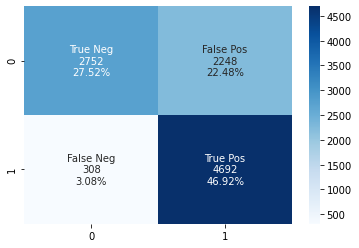

In [47]:
plot_matrix(conf_mat)

# TESTING

In [48]:

def predict(question1, question2, threshold, model, vocab, data_generator=batch_generator, verbose=False):
    
    q1 = [porter.stem(w) for w in (text_to_word_list(question1))]  
    q2 = [porter.stem(w) for w in (text_to_word_list(question2))]
    Q1, Q2 = [], []
    for word in q1:  
        Q1.append(vocab[word])
    for word in q2:  
        Q2.append(vocab[word])
        
  
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, pad = vocab['<PAD>']))
   
    v1, v2 = model((Q1, Q2))

    d = np.dot(v1[0], v2[0].T)
    
    res = d > threshold
    

    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

In [49]:
question1 = "When will I see you again?"
question2 = "When can I see you again?"

predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[ 323   64    4   37   43 2684    1    1]] 
Q2  =  [[ 323   24    4   37   43 2684    1    1]]
d   =  0.97889924
res =  True


True

In [53]:
question1 = "Where do you live?"
question2 = "Where is your home?"

predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[572  29  43 375]] 
Q2  =  [[572 134  45 663]]
d   =  0.8345728
res =  True


True

In [54]:
question1 = "Where is your University at?"
question2 = "What subject are you doing your major on?"

predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[572 134  45 486 116   1   1   1]] 
Q2  =  [[  13 4742   74   43   29   45  236   60]]
d   =  0.2726935
res =  False


False